In [14]:
# ============================================================================
# CELL 12: PERFORMANCE METRICS
# ============================================================================
print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)

# Drawdown
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
max_dd = drawdown.min()

# Calculate metrics
total_ret = (cumulative.iloc[-1] - 1) * 100
ann_ret = port_returns_net.mean() * 252 * 100
ann_vol = port_returns_net.std() * np.sqrt(252) * 100
sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
calmar = ann_ret / abs(max_dd * 100) if max_dd != 0 else 0

win_rate = (port_returns_net > 0).sum() / len(port_returns_net) * 100
wins = port_returns_net[port_returns_net > 0].sum()
losses = abs(port_returns_net[port_returns_net < 0].sum())
profit_factor = wins / losses if losses > 0 else np.inf

monthly = port_returns_net.resample('M').sum()

metrics = {
    'Total Return (%)': total_ret,
    'Annualized Return (%)': ann_ret,
    'Annualized Vol (%)': ann_vol,
    'Sharpe Ratio': sharpe,
    'Max Drawdown (%)': max_dd * 100,
    'Calmar Ratio': calmar,
    'Win Rate (%)': win_rate,
    'Profit Factor': profit_factor,
    'Best Month (%)': monthly.max() * 100,
    'Worst Month (%)': monthly.min() * 100,
}

for key, val in metrics.items():
    print(f"  {key:.<40} {val:>10.2f}")


PERFORMANCE METRICS
  Total Return (%)........................      36.64
  Annualized Return (%)...................       5.40
  Annualized Vol (%)......................       5.65
  Sharpe Ratio............................       0.96
  Max Drawdown (%)........................      -8.02
  Calmar Ratio............................       0.67
  Win Rate (%)............................      51.30
  Profit Factor...........................       1.20
  Best Month (%)..........................       6.59
  Worst Month (%).........................      -3.01



CREATING CHARTS...


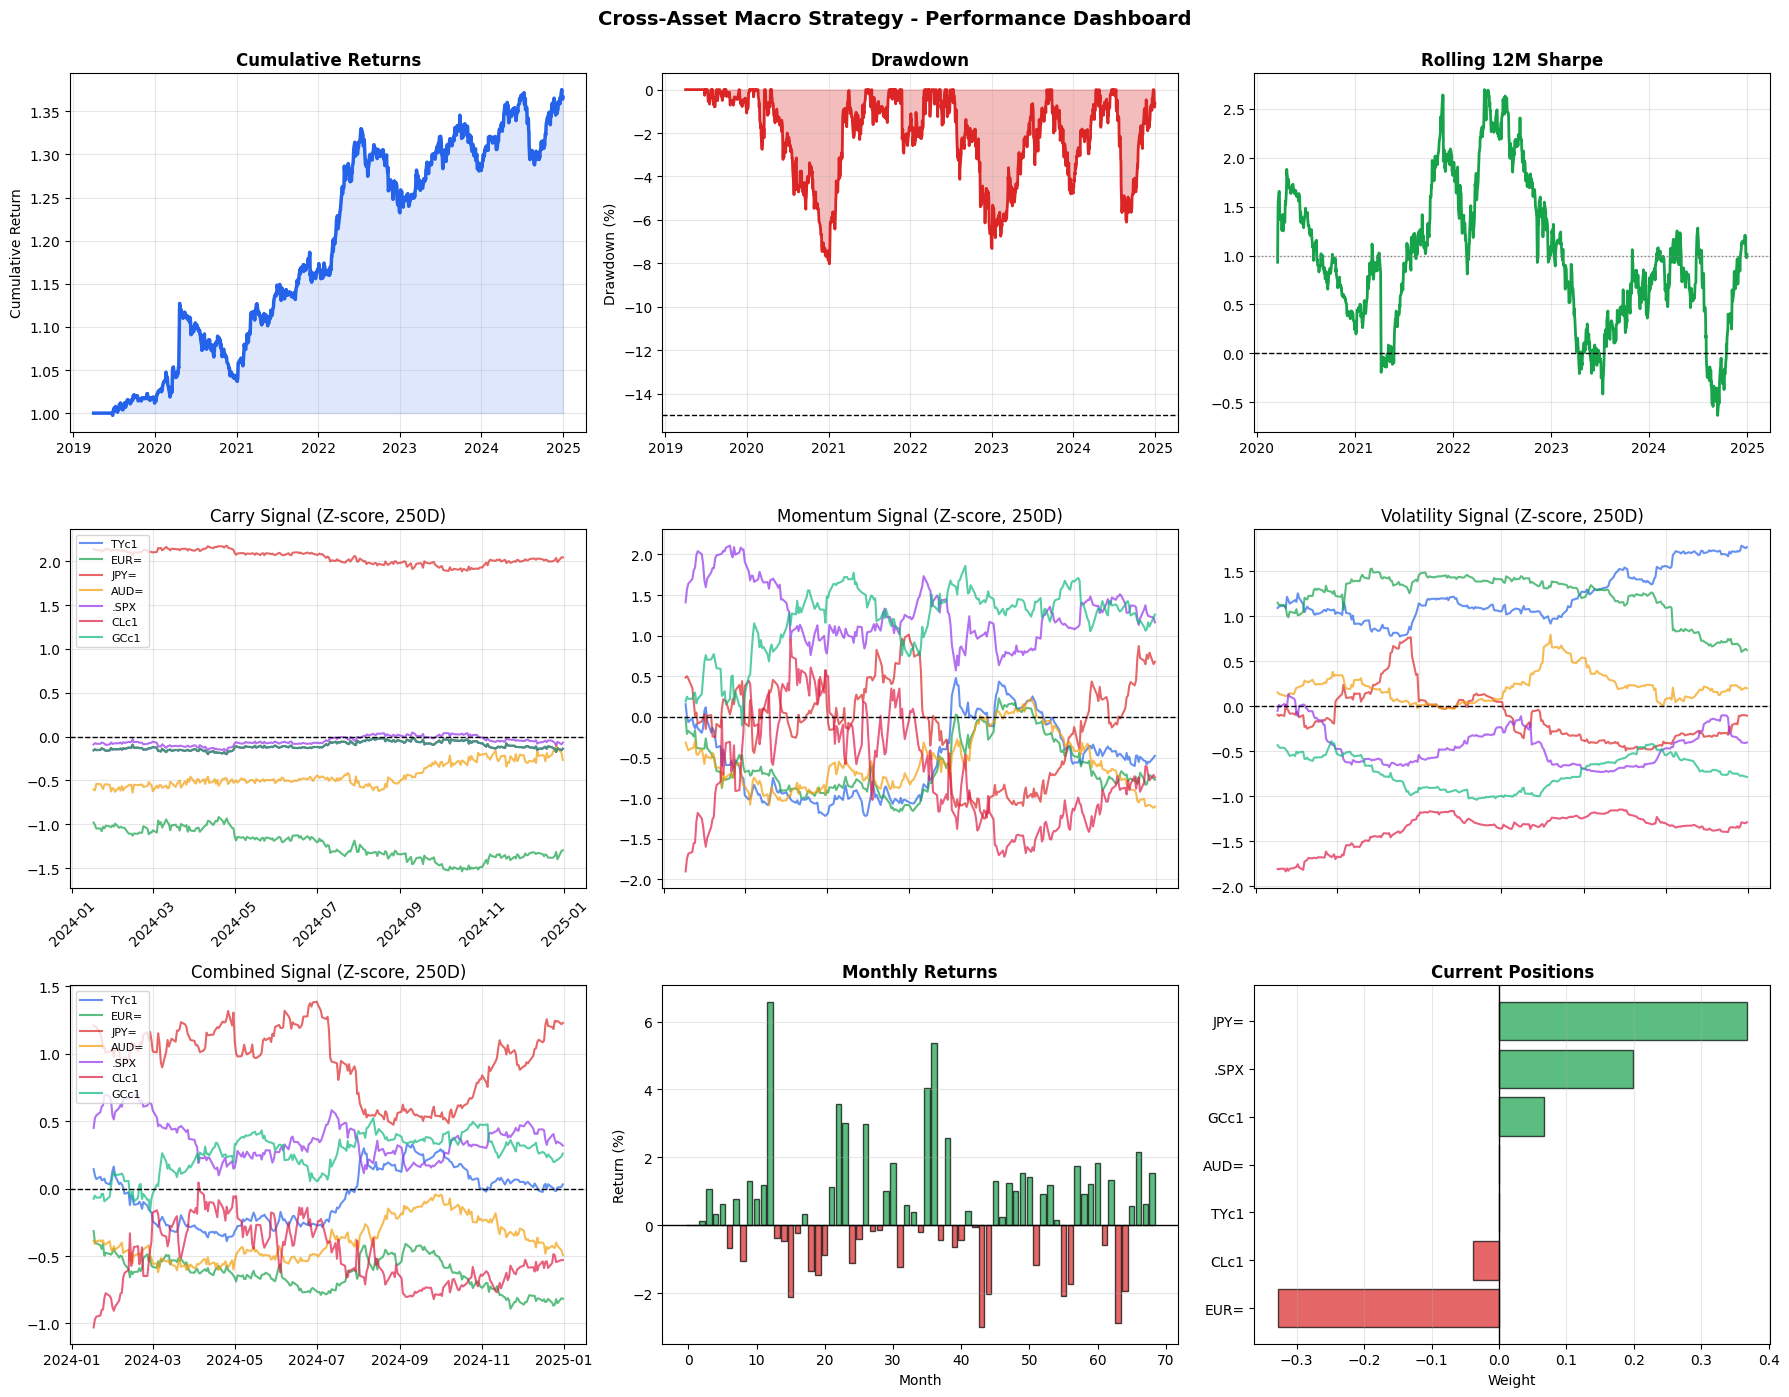

✓ Charts created

STRATEGY VS SPX


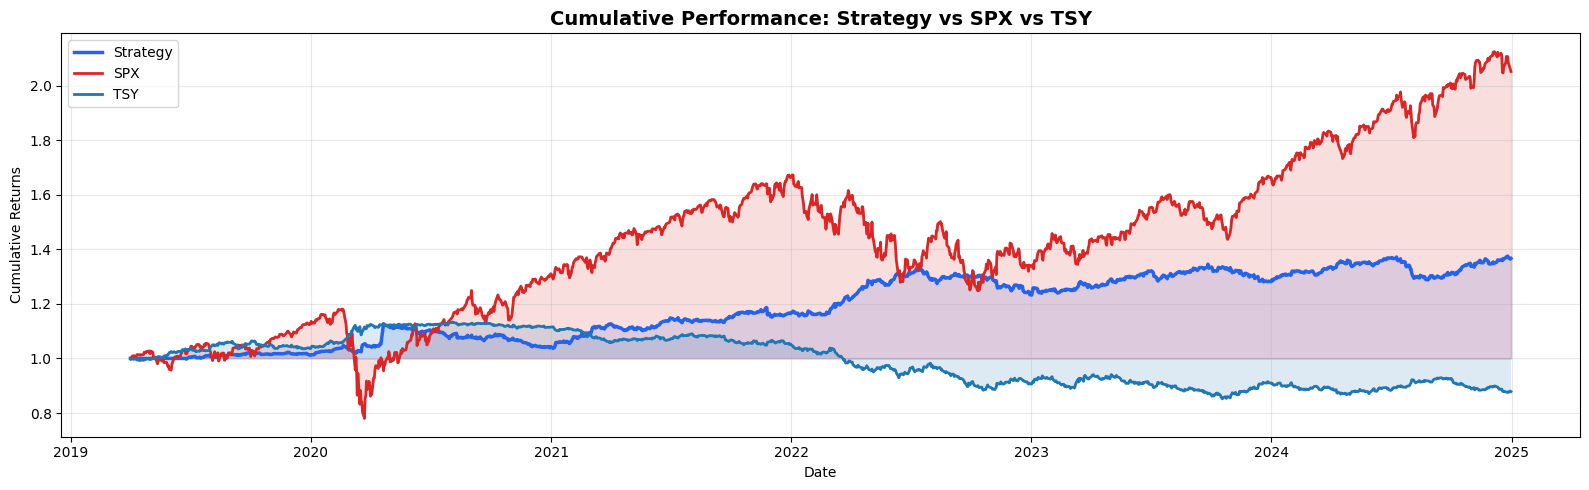

In [16]:
# ============================================================================
# CELL 13: VISUALIZATION FIXED (LABELS & COLORS)
# ============================================================================
print("\n" + "="*60)
print("CREATING CHARTS...")
print("="*60)

fig, axes = plt.subplots(3, 3, figsize=(18, 14))

plot_window = 250
signal_alpha = 0.7
signal_lw = 1.5

# =========================
# ROW 1 — PERFORMANCE
# =========================

# 1. Cumulative returns
ax = axes[0, 0]
ax.plot(cumulative.index, cumulative, linewidth=2.5, color='#2563eb')
ax.fill_between(cumulative.index, 1, cumulative, alpha=0.15, color='#2563eb')
ax.set_title('Cumulative Returns', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.grid(alpha=0.3)

# 2. Drawdown
ax = axes[0, 1]
ax.fill_between(drawdown.index, drawdown*100, 0, alpha=0.3, color='#dc2626')
ax.plot(drawdown.index, drawdown*100, linewidth=2, color='#dc2626')
ax.axhline(-15, color='black', linestyle='--', linewidth=1)
ax.set_title('Drawdown', fontsize=12, fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.grid(alpha=0.3)

# 3. Rolling Sharpe
ax = axes[0, 2]
rolling_sharpe = (port_returns_net.rolling(252).mean() / 
                 port_returns_net.rolling(252).std() * np.sqrt(252))
ax.plot(rolling_sharpe.index, rolling_sharpe, linewidth=2, color='#16a34a')
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.axhline(1, color='gray', linestyle=':', linewidth=1)
ax.set_title('Rolling 12M Sharpe', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# =========================
# ROW 2 — SIGNALS (LAST 250 DAYS)
# =========================

# 4. Carry signal (with labels)
ax = axes[1, 0]
colors = ['#2563eb', '#16a34a', '#dc2626', '#f59e0b', '#9333ea', '#e11d48', '#10b981']  # cycle
for i, c in enumerate(carry_zscore.columns):
    ax.plot(carry_zscore.tail(plot_window).index, carry_zscore.tail(plot_window)[c],
            label=c, linewidth=signal_lw, alpha=signal_alpha, color=colors[i % len(colors)])
ax.axhline(0, linestyle='--', linewidth=1, color='black')
ax.set_title('Carry Signal (Z-score, 250D)')
ax.tick_params(axis='x', rotation=45)
ax.grid(alpha=0.3)

# Add this line to show labels
ax.legend(loc='upper left', fontsize=8)

# 5. Momentum signal (no labels, same colors)
ax = axes[1, 1]
for i, c in enumerate(momentum_zscore.columns):
    ax.plot(momentum_zscore.tail(plot_window).index, momentum_zscore.tail(plot_window)[c],
            linewidth=signal_lw, alpha=signal_alpha, color=colors[i % len(colors)])
ax.axhline(0, linestyle='--', linewidth=1, color='black')
ax.set_title('Momentum Signal (Z-score, 250D)')
ax.set_xticklabels([])
ax.grid(alpha=0.3)

# 6. Volatility signal (z-score, same colors)
ax = axes[1, 2]
for i, c in enumerate(volatility_zscore.columns):
    ax.plot(volatility_zscore.tail(plot_window).index, volatility_zscore.tail(plot_window)[c],
            linewidth=signal_lw, alpha=signal_alpha, color=colors[i % len(colors)])
ax.axhline(0, linestyle='--', linewidth=1, color='black')
ax.set_title('Volatility Signal (Z-score, 250D)')
ax.set_xticklabels([])
ax.grid(alpha=0.3)

# =========================
# ROW 3 — COMBINED / MONTHLY / POSITIONS
# =========================

# 7. Combined signal (last 250 days, same colors)
ax = axes[2, 0]
for i, c in enumerate(combined_signal.columns):
    ax.plot(combined_signal.tail(plot_window).index, combined_signal.tail(plot_window)[c],label=c,
            linewidth=signal_lw, alpha=signal_alpha, color=colors[i % len(colors)])
ax.axhline(0, linestyle='--', linewidth=1, color='black')
ax.set_title('Combined Signal (Z-score, 250D)')
ax.grid(alpha=0.3)

# Add this line to show labels
ax.legend(loc='upper left', fontsize=8)

# 8. Monthly returns (month labels)
ax = axes[2, 1]
monthly_pct = monthly * 100
colors = ['#16a34a' if x > 0 else '#dc2626' for x in monthly_pct]
ax.bar(range(len(monthly_pct)), monthly_pct, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linewidth=1)
ax.set_title('Monthly Returns', fontsize=12, fontweight='bold')
ax.set_ylabel('Return (%)')
ax.set_xlabel('Month')
ax.grid(alpha=0.3, axis='y')


# 9. Latest positions
ax = axes[2, 2]
latest_weights = weights_vol_scaled.iloc[-1].sort_values()
colors_pos = ['#dc2626' if x < 0 else '#16a34a' for x in latest_weights]
ax.barh(latest_weights.index, latest_weights, color=colors_pos, alpha=0.7, edgecolor='black')
ax.axvline(0, color='black', linewidth=1)
ax.set_title('Current Positions', fontsize=12, fontweight='bold')
ax.set_xlabel('Weight')
ax.grid(alpha=0.3, axis='x')

plt.suptitle('Cross-Asset Macro Strategy - Performance Dashboard', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Charts created")


# ============================================================================
# STRATEGY VS .SPX
# ============================================================================
print("\n" + "="*60)
print("STRATEGY VS SPX")
print("="*60)

plt.figure(figsize=(16, 5))

# Cumulative strategy returns
plt.plot(cumulative.index, cumulative, label='Strategy', linewidth=2.5, color='#2563eb')
plt.fill_between(cumulative.index, 1, cumulative, alpha=0.15, color='#2563eb')

# Cumulative SPX returns
if '.SPX' in prices_clean.columns:
    spx_cum = (1 + returns['.SPX']).cumprod()
    plt.plot(spx_cum.index, spx_cum, label='SPX', linewidth=2, color='#dc2626')
    plt.fill_between(spx_cum.index, 1, spx_cum, alpha=0.15, color='#dc2626')

# Cumulative SPX returns
if 'TYc1' in prices_clean.columns:
    tsy_cum = (1 + returns['TYc1']).cumprod()
    plt.plot(tsy_cum.index, tsy_cum, label='TSY', linewidth=2 )
    plt.fill_between(tsy_cum.index, 1, tsy_cum, alpha=0.15)

plt.title('Cumulative Performance: Strategy vs SPX vs TSY', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.grid(alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

